<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/Milestone_Project_1_Food_Vision_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/tree/main

## Check GPU

Google Colab offers free GPUs, However, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: [NVIDIA GPU recommendation](https://developer.nvidia.com/cuda-gpus))

In [1]:
!nvidia-smi

Mon Mar 25 11:52:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac9b3cda-22d0-6be6-1022-5ae009a1cfdc)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: [helper.py](https://github.com/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/HelperFunctions/helper.py)

In [3]:
# Download helper functons script
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py

--2024-03-25 11:52:13--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16635 (16K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.25K  --.-KB/s    in 0s      

2024-03-25 11:52:13 (151 MB/s) - ‘helper.py’ saved [16635/16635]



In [4]:
# Import series of helper functions for the notebook
from helper import Visualize, Callback, Prediction, DataHandler, ModelEvaluation

## Use TensorFlow Datasets to Download data

Overview of [TensorFlow Datasets](https://www.tensorflow.org/datasets)

The list of datasets contain our [Food101 Dataset](https://www.tensorflow.org/datasets/catalog/food101)

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# List all available datasets
datasets_list = tfds.list_builders() # get all the available datasets in TFDS
print('food101' in datasets_list) # check if food101 is in the list

True


In [7]:
# Load in the data (taken 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             with_info=True,
                                             as_supervised=True) # data is returned in a tuple format as image, label

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0LCUOL/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete0LCUOL/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded)
* Do the labels match up with the class names?

In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)  # samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data loook like
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name from Food101 (string form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name from Food101 (string form): french_onion_soup
  


In [13]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [14]:
label.numpy()

41

In [15]:
# What are the min and max of our image tensor?
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

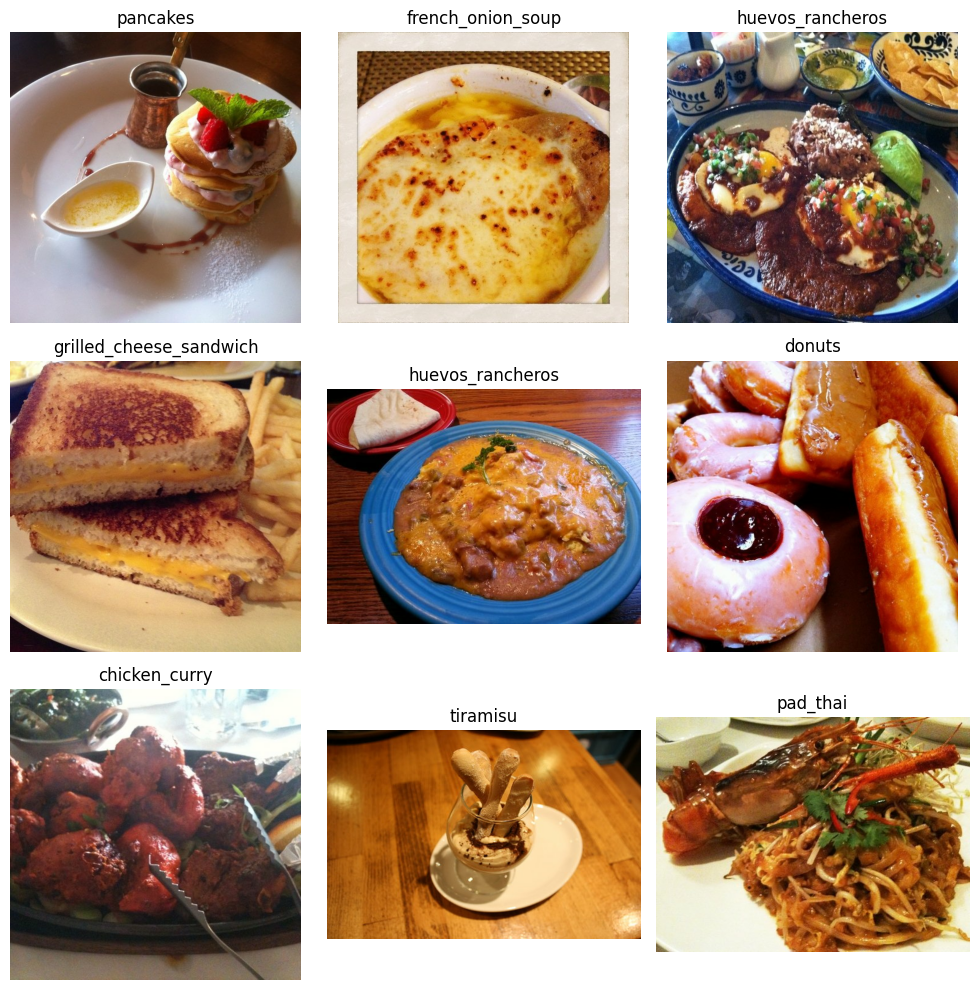

In [16]:
# Plot image tensors
import matplotlib.pyplot as plt
import random

# When your data is a collection of tuples (image, label)
def view_random_images(train_data):
  """
  View a random image from the training data
  """

  # Create a subplot
  plt.figure(figsize=(10, 10))
  for i in range(9):
    # Choose a random image
    random_sample = train_data.take(1)

    # Extract image and label
    for image, label in random_sample:
      # plot the image
      plt.subplot(3, 3, i+1)
      plt.imshow(image.numpy())
      plt.axis('off')
      plt.title(class_names[label.numpy()])

  plt.tight_layout()
  plt.show()

view_random_images(train_data)

## Create preprocessing functions for our data

Neural networks perform best when the data is in certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural netowrk, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors  (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or form mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called as normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we;re going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:

1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from uint8 to float32

In [17]:
def preprocess(image, label, img_shape=224):
  """
  Reshape and convert the image tensor to float32
  """
  # Reshape image to 224x224x3
  image = tf.image.resize(image, (img_shape, img_shape))

  # Convert image to float32
  image = tf.image.convert_image_dtype(image, tf.float32)

  return image, label # retunr a tuple (float32_img, label)

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess(image, label)[0]
print(f'Image before preprocessing: {image[:2]}..., \nShape: {image.shape}, \n dtype: {image.dtype}')
print(f'Image after preprocessing: {preprocessed_img[:2]}... \nShape: {preprocessed_img.shape}, \n dtype: {preprocessed_img.dtype}')

Image before preprocessing: [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]..., 
Shape: (512, 512, 3), 
 dtype: <dtype: 'uint8'>
Image after preprocessing: [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]... 
Shape: (224, 224, 3), 
 dtype: <dtype: 'float32'>


## Batch and Prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, go thorugh the following guide: [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

In [19]:
# Map preprocessing function to training (and parllelize)
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1024).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

# Map the preprocessing function to test data
test_data = test_data.map(preprocess).batch(batch_size=64).prefetch(tf.data.AUTOTUNE).cache()

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> Hey, TensorFlow, map this preprocessing function (`preprocess`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

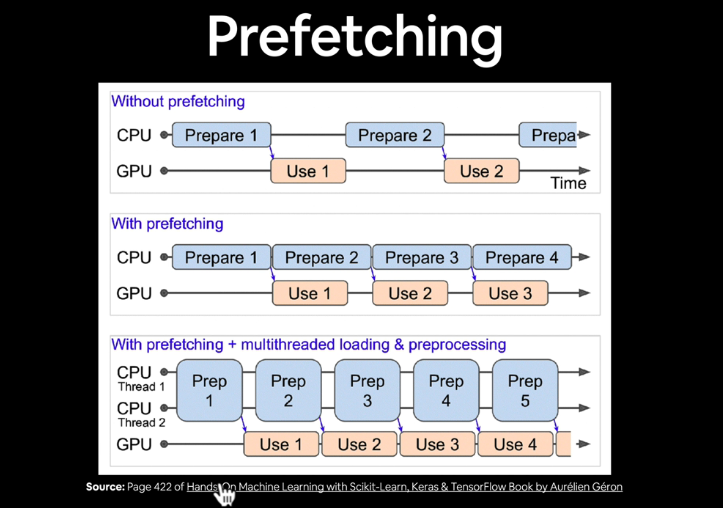

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [21]:
# Create a checkpoint path
checkpoint_path = '/content/drive/MyDrive/TensorFlow/Food-Vision/Checkpoints/model_0_checkpoint'
model_checkpoint_callback = Callback.model_checkpoint(checkpoint_path=checkpoint_path)

# Setup early_stopping and save the best
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Create a tensorboard callback
dir_name = '/content/drive/MyDrive/TensorFlow/Food-Vision/logs'
tensorboard_callback = Callback.create_tensorboard(dir_name=dir_name,
                                                   experiment_name='model_0')


Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow/Food-Vision/logs/model_0/20240325-120331


## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the [TensorFLow guide for mixed precision](https://www.tensorflow.org/guide/mixed_precision)

Mixed precision utilizes a combination of float32 and float16  dtypes to speed up the model performance. So basically, computations are done in float16 for faster performance and variables are kept in float32 for numeric stability

In [ ]:
# Turn on mixed precision training
# from tensorflow.keras import mixed_precision

# # mixed_precision.set_global_policy('mixed_float16') # set global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [ ]:
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

## Create a feature extraction model using mixed precision training

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Turn on mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Download base model and freeze underlying layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False  # Freeze all the layers in the base_model

# Create a functional model from the above base_model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
# Mixed precision requires output layer to have dtype=tf.float32
outputs = layers.Activation('softmax', dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is they layer trainable or not? (if `False`, the weights are Frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its layer computes on its variables with

In [28]:
# Check for the mp_model
for layer in model.layers:
  # Check the layer dtype
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
activation_1 True float32 <Policy "float32">


In [29]:
# check the base_model
for layer in model.layers[1].layers: # Check the layers of the base model
  # Check the layer dtype
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the layer dtype

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

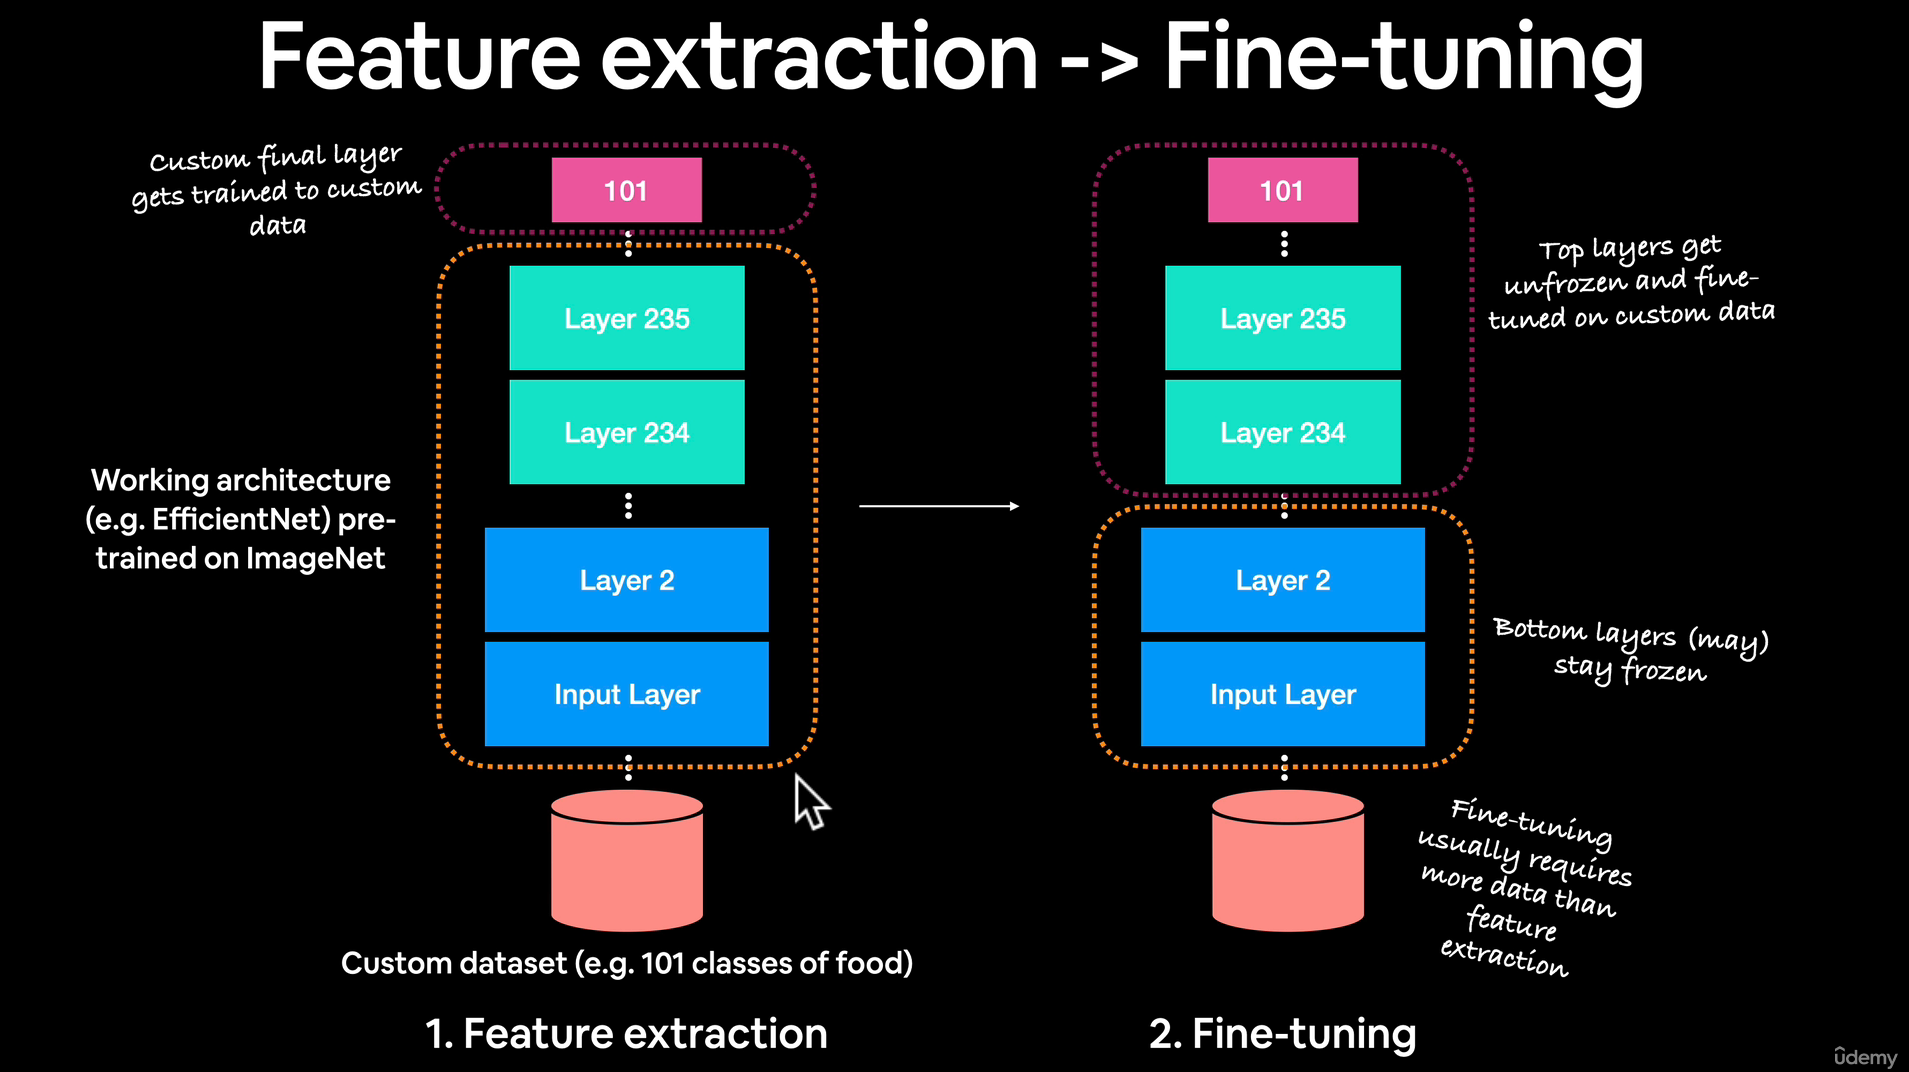

In [30]:
# Fit the feature extraction model with callbacks
history_01 = model.fit(train_data, epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)),
                       callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/5
1184/1184 [==============================] - 107s 81ms/step - loss: 2.2252 - accuracy: 0.5051 - val_loss: 1.4231 - val_accuracy: 0.6438
Epoch 2/5
1184/1184 [==============================] - 92s 77ms/step - loss: 1.4825 - accuracy: 0.6306 - val_loss: 1.2315 - val_accuracy: 0.6825
Epoch 3/5
1184/1184 [==============================] - 92s 77ms/step - loss: 1.3209 - accuracy: 0.6644 - val_loss: 1.1597 - val_accuracy: 0.6928
Epoch 4/5
1184/1184 [==============================] - 92s 77ms/step - loss: 1.2250 - accuracy: 0.6868 - val_loss: 1.1002 - val_accuracy: 0.7079
Epoch 5/5
1184/1184 [==============================] - 92s 77ms/step - loss: 1.1586 - accuracy: 0.7022 - val_loss: 1.0728 - val_accuracy: 0.7116


In [34]:
# Evaluate the model
results_01 = model.evaluate(test_data)
results_01

395/395 [==============================] - 25s 62ms/step - loss: 1.0795 - accuracy: 0.7105


[1.0794552564620972, 0.7104554176330566]

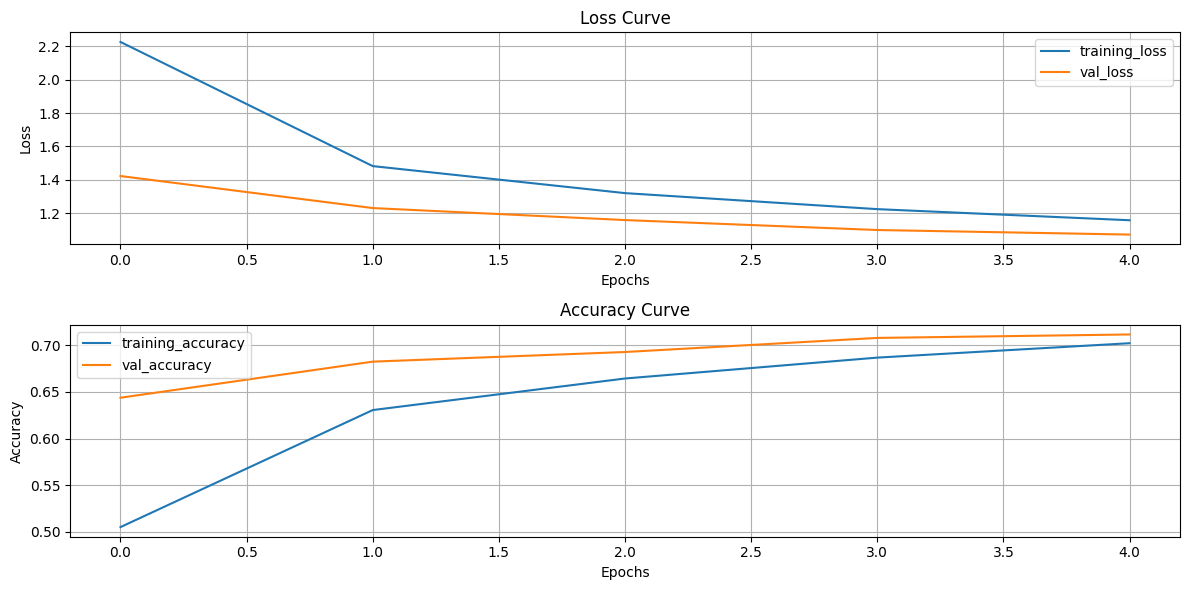

In [35]:
ModelEvaluation.loss_acc_curves(history_01)

In [36]:
model.load_weights(checkpoint_path)

In [38]:
# unfreeze a few layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-8]:

    layer.trainable = False

# Recompile our model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the mode
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 1022613 

In [39]:
# check the base_model
for layer in model.layers[1].layers: # Check the layers of the base model
  # Check the layer dtype
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the layer dtype

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

In [40]:
# Create a checkpoint path
checkpoint_path = '/content/drive/MyDrive/TensorFlow/Food-Vision/Checkpoints/model_0_checkpoint'
model_checkpoint_callback = Callback.model_checkpoint(checkpoint_path=checkpoint_path)

# Setup early_stopping and save the best
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Create a tensorboard callback
dir_name = '/content/drive/MyDrive/TensorFlow/Food-Vision/logs'
tensorboard_callback = Callback.create_tensorboard(dir_name=dir_name,
                                                   experiment_name='model_0')


Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow/Food-Vision/logs/model_0/20240325-122126


In [41]:
initial_epochs = 5

# Fit the model
history_02 = model.fit(train_data, initial_epoch=initial_epochs,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.15*len(test_data)),
                       callbacks=[Callback.model_checkpoint(checkpoint_path='/content/drive/MyDrive/TensorFlow/Food-Vision/Checkpoints/model_1_checkpoint'),
                                  early_stopping_callback, Callback.create_tensorboard(dir_name=dir_name, experiment_name='model_1')])

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow/Food-Vision/logs/model_1/20240325-122142
Epoch 6/100
1184/1184 [==============================] - 106s 81ms/step - loss: 1.1039 - accuracy: 0.7166 - val_loss: 1.0309 - val_accuracy: 0.7246
Epoch 7/100
1184/1184 [==============================] - 97s 81ms/step - loss: 1.0096 - accuracy: 0.7370 - val_loss: 0.9850 - val_accuracy: 0.7346
Epoch 8/100
1184/1184 [==============================] - 95s 79ms/step - loss: 0.9546 - accuracy: 0.7526 - val_loss: 0.9565 - val_accuracy: 0.7365
Epoch 9/100
1184/1184 [==============================] - 94s 79ms/step - loss: 0.9093 - accuracy: 0.7616 - val_loss: 0.9349 - val_accuracy: 0.7389
Epoch 10/100
1184/1184 [==============================] - 97s 81ms/step - loss: 0.8699 - accuracy: 0.7730 - val_loss: 0.9269 - val_accuracy: 0.7474
Epoch 11/100
1184/1184 [==============================] - 97s 81ms/step - loss: 0.8353 - accuracy: 0.7798 - val_loss: 0.9066 - val_accuracy: 0.7540
Epoch 1

In [42]:
# Evaluate our model on whole dataset
results_02 = model.evaluate(test_data, verbose=1)
results_02

395/395 [==============================] - 25s 63ms/step - loss: 0.8655 - accuracy: 0.7611


[0.8654801249504089, 0.7610692977905273]

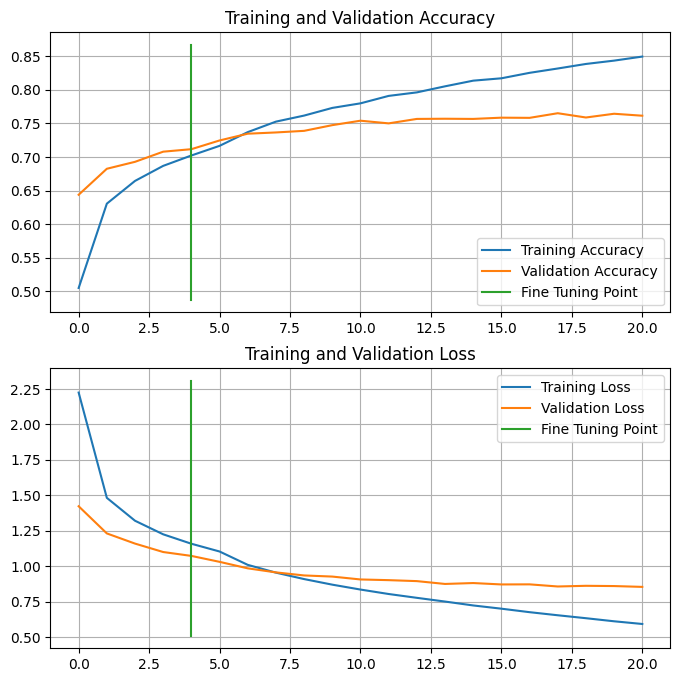

In [43]:
ModelEvaluation.compare_history(history_01, history_02)

In [44]:
# let's go ahead and save the model
model.save('/content/drive/MyDrive/TensorFlow/Food-Vision/models/model_01.keras')